In [1]:
import os
os.chdir('/content/drive/MyDrive/9조 프로젝트/Data/Dataset')

In [2]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00


In [3]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "google/vit-base-patch16-224-in21k"  # embedding matrix  N X 768
#model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size # 768

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [4]:
from datasets import load_from_disk

dataset_dict = load_from_disk("my-arrow-datasets")

In [5]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['img_file_path', 'image', 'label'],
        num_rows: 15493
    })
    test: Dataset({
        features: ['img_file_path', 'image', 'label'],
        num_rows: 1943
    })
})

In [6]:
subset = dataset_dict['train']

In [7]:
labels = dataset_dict["train"].features["label"].names
label2id, id2label = dict(), dict() # label : index / index : label

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [8]:
import torchvision.transforms as T


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize((224, 224)),
        #T.Resize(int((256 / 224) * extractor.size["height"])),
        #T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [9]:
import torch

def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        # `transformation_chain` is a compostion of preprocessing
        # transformations we apply to the input images to prepare them
        # for the model. For more details, check out the accompanying Colab Notebook.
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu() # 임베딩 계산
        return {"embeddings": embeddings}

    return pp

In [10]:
subset = dataset_dict['train']

In [11]:
batch_size = 1024
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device)) # 임베딩 추출함수 생성
subset_emb = subset.map(extract_fn, batched=True, batch_size=1024) # subset 데이터셋에 맞게 extract_fn 적용하여 임베딩 계산

Map:   0%|          | 0/15493 [00:00<?, ? examples/s]

In [ ]:
subset_emb

In [12]:
from tqdm.auto import tqdm

candidate_ids = []

for id in tqdm(range(len(subset_emb))):
    label = subset_emb[id]["label"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry) # idx _ label

  0%|          | 0/15493 [00:00<?, ?it/s]

In [13]:
import numpy as np

all_candidate_embeddings = np.array(subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings) # tensor

In [14]:
all_candidate_embeddings.size()

torch.Size([15493, 768])

In [53]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=25):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings) # train vs test(query)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))

    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)  # sim_scores로 내림차순
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels

In [41]:
test_idx=1866

In [54]:
#test_idx = np.random.choice(len(dataset_dict["test"]))
test_sample = dataset_dict["test"][test_idx]["image"]
test_label = dataset_dict["test"][test_idx]["label"]

sim_ids, sim_labels = fetch_similar(test_sample)
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")

Query label: 7
Top 5 candidate labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


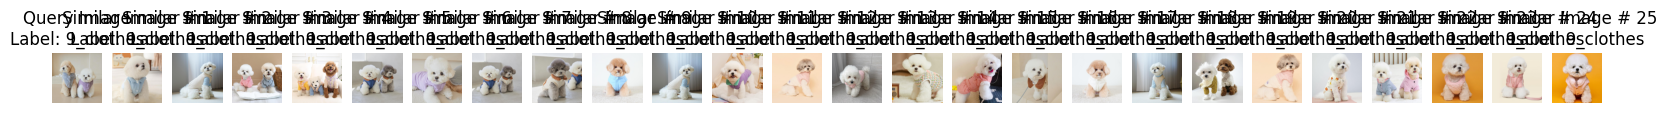

In [55]:
import matplotlib.pyplot as plt


def plot_images(images, labels):
    if not isinstance(labels, list): # labels이 list가 아니면
        labels = labels.tolist()     # lablels를 list로 바꿔라

    plt.figure(figsize=(20, 10))
    columns = 26  # 쿼리1 + 유사5
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(subset_emb[id]["image"])
    labels.append(subset_emb[id]["label"])

images.insert(0, test_sample) # images의 0 인덱스에 test_sample 추가
labels.insert(0, test_label)
plot_images(images, labels)

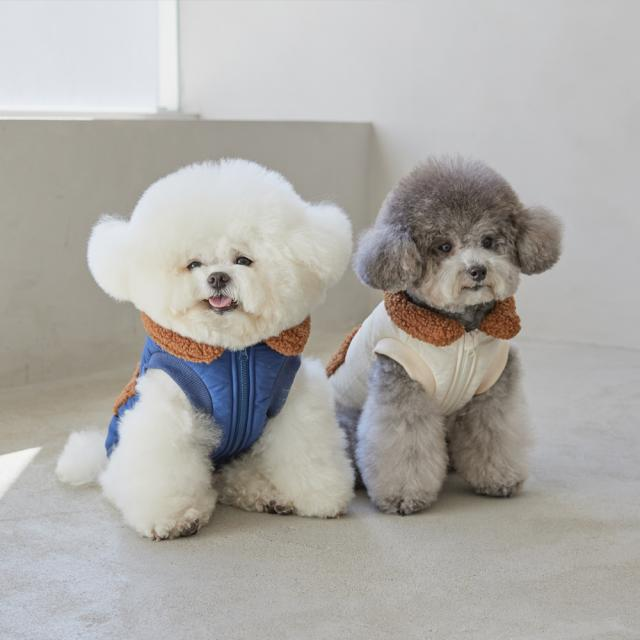

In [49]:
images[5]

임베딩을 있는 그대로 저장하면 특히 수백만 개의 후보 이미지를 처리할 때 메모리 요구 사항이 빠르게 증가할 수 있다.

-> 임베딩 차원 줄임 : 벡터 그룹 간 거리가 평면에서 보존되면, 평면의 차원성 감소  
-> 예측된 벡터의 비트 단위 해시 값 계산하여 해시 버킷 결정 : 비슷한 이미지는 임베딩 공간에서 더 가까울 것이고, 동일한 해시 값을 가질 가능성이 높다.

* 해시 값을 저장하고 운영하는 것이 더 저렴